In [6]:
from Module.MySQL_connector import MySQLConnector
import pandas as pd
import os

In [3]:
# import data from MySQL
sql_connector = MySQLConnector('192.168.31.130', 'bigred', 'bigred', 32010)
sql_connector.connectDB('g3_db')
# print(sql_connector.execute_query('show tables;'))
sql_connector.execute_query('show tables;')
main_table = pd.DataFrame(sql_connector.execute_query("select * from main_aa"))
genres_onehot = pd.DataFrame(sql_connector.execute_query("select * from genres_onehot_aa"))
features_onehot = pd.DataFrame(sql_connector.execute_query("select * from features_onehot_aa"))
tags_onehot = pd.DataFrame(sql_connector.execute_query("select * from tags_onehot_aa"))
id_publisher_aa = pd.DataFrame(sql_connector.execute_query("select * from id_publishers_aa"))
publishers_info_aa = pd.DataFrame(sql_connector.execute_query("select * from publishers_info_aa;"))

Connected to g3_db on 192.168.31.130:32010


In [10]:
# import data from CSV
main_table = pd.read_csv('../../data/AA/main_aa.csv')


In [4]:
copiesold = pd.DataFrame(sql_connector.execute_query("select * from first30days_sales_2A"))

In [5]:
copiesold = copiesold.drop(columns=['timeStamp','releaseDate','days_since_release'])


In [27]:
id_publisher_aa

,steamId,publisher
0,1623730,Pocketpair
1,252490,Facepunch Studios
2,275850,Hello Games
3,1326470,Newnight
4,346110,Studio Wildcard
...,...,...
2759,8170,Square Enix
2760,4760,SEGA
2761,4770,SEGA
2762,45720,Capcom


In [6]:
# 合併時指定 suffixes 參數來處理重複列
merged_table = pd.merge(main_table, genres_onehot, on='steamId', suffixes=('', '_genres'))
merged_table = pd.merge(merged_table, tags_onehot, on='steamId', suffixes=('', '_tags'))
# 再次合併時，處理更多的重複列
merged_table = pd.merge(merged_table, features_onehot, on='steamId', suffixes=('', '_features'))


In [7]:
# 找到所有帶有 '_tags' 或 '_features' 後綴的列名
replicated_columns = [col for col in merged_table.columns if '_tags' in col or '_features' in col]

# 刪除這些列
merged_table.drop(columns=replicated_columns, inplace=True)

In [ ]:
for item in merged_table.columns:
    print(item)

In [8]:
cs_pub = pd.merge(copiesold,id_publisher_aa,on="steamId")
# cs_pub_info = pd.merge(cs_pub, publishers_info_aa, on="steamId")
cs_pub_info = pd.merge(cs_pub, publishers_info_aa, left_on='publisher', right_on="name")
cs_pub_info

,steamId,sales,publisher,name,averageRevenue,medianRevenue,totalRevenue,publishedGames
0,41050,0.000000e+00,Devolver Digital,Devolver Digital,3.097318e+06,555213.0,3.933594e+08,127
1,41060,5.691300e+04,Devolver Digital,Devolver Digital,3.097318e+06,555213.0,3.933594e+08,127
2,208650,1.796316e+05,WB Games,WB Games,2.301824e+07,21042950.0,1.841459e+08,8
3,220200,1.099500e+06,Private Division,Private Division,1.259276e+07,2115005.0,1.385203e+08,11
4,223100,5.393900e+04,Deep Silver,Deep Silver,6.568174e+06,2458665.0,2.298861e+08,35
...,...,...,...,...,...,...,...,...
1240,2881650,1.050977e+06,Landfall,Landfall,8.568731e+06,5725398.0,5.998112e+07,7
1241,2903950,4.581000e+03,"Spike Chunsoft Co., Ltd.","Spike Chunsoft Co., Ltd.",1.565075e+06,425891.5,7.825373e+07,50
1242,2933080,9.695800e+04,505 Games,505 Games,3.749863e+06,708029.0,1.837433e+08,49
1243,2969380,2.590000e+03,"Spike Chunsoft Co., Ltd.","Spike Chunsoft Co., Ltd.",1.565075e+06,425891.5,7.825373e+07,50


In [9]:
cs_pub_info=cs_pub_info.dropna()

In [46]:
cs_pub_info

,steamId,sales,publisher,name,averageRevenue,medianRevenue,totalRevenue,publishedGames
0,41050,0.000000e+00,Devolver Digital,Devolver Digital,3.097318e+06,555213.0,3.933594e+08,127
1,41060,5.691300e+04,Devolver Digital,Devolver Digital,3.097318e+06,555213.0,3.933594e+08,127
2,208650,1.796316e+05,WB Games,WB Games,2.301824e+07,21042950.0,1.841459e+08,8
3,220200,1.099500e+06,Private Division,Private Division,1.259276e+07,2115005.0,1.385203e+08,11
4,223100,5.393900e+04,Deep Silver,Deep Silver,6.568174e+06,2458665.0,2.298861e+08,35
...,...,...,...,...,...,...,...,...
1240,2881650,1.050977e+06,Landfall,Landfall,8.568731e+06,5725398.0,5.998112e+07,7
1241,2903950,4.581000e+03,"Spike Chunsoft Co., Ltd.","Spike Chunsoft Co., Ltd.",1.565075e+06,425891.5,7.825373e+07,50
1242,2933080,9.695800e+04,505 Games,505 Games,3.749863e+06,708029.0,1.837433e+08,49
1243,2969380,2.590000e+03,"Spike Chunsoft Co., Ltd.","Spike Chunsoft Co., Ltd.",1.565075e+06,425891.5,7.825373e+07,50


In [10]:

full_table = pd.merge(cs_pub_info, merged_table, on="steamId",suffixes=('', '_pub'))
# full_table = pd.merge(merged_table, copiesold, on="steamId")


In [58]:
for item in full_table:
    print(item)

steamId
sales
publisher
name
averageRevenue
medianRevenue
totalRevenue
publishedGames
name_pub
price
reviews
reviewsSteam
followers
avgPlaytime
reviewScore
releaseDate
firstReleaseDate
earlyAccess
copiesSold
revenue
totalRevenue_pub
players
owners
wishlists
Action
Adventure
Casual
Early Access
Indie
Massively Multiplayer
RPG
Racing
Simulation
Sports
Strategy
1980s
1990's
2.5D
2D
2D Fighter
2D Platformer
360 Video
3D
3D Fighter
3D Platformer
3D Vision
4 Player Local
4X
6DOF
ATV
Abstract
Action RPG
Action RTS
Action Roguelike
Action-Adventure
Addictive
Agriculture
Aliens
Alternate History
Ambient
America
Animation & Modeling
Anime
Arcade
Archery
Arena Shooter
Artificial Intelligence
Assassin
Asymmetric VR
Asynchronous Multiplayer
Atmospheric
Auto Battler
Automation
Automobile Sim
BMX
Base Building
Baseball
Based On A Novel
Basketball
Battle Royale
Beat 'em up
Beautiful
Benchmark
Bikes
Birds
Blood
Board Game
Boomer Shooter
Boss Rush
Bowling
Boxing
Building
Bullet Hell
Bullet Time
CRPG
Cap

In [11]:
columns_to_drop = ['steamId','totalRevenue_pub','publisher','name_pub','name','reviews','reviewsSteam','followers','avgPlaytime','reviewScore','releaseDate','firstReleaseDate','copiesSold','revenue','totalRevenue','players','owners','wishlists']
full_table=full_table.drop(columns=columns_to_drop)

In [12]:
full_table[['publishedGames','medianRevenue','averageRevenue']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1244 entries, 0 to 1243
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   publishedGames  1244 non-null   int64  
 1   medianRevenue   1244 non-null   float64
 2   averageRevenue  1244 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 29.3 KB


In [13]:
full_table = full_table.dropna()

In [78]:
!pip install scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 53.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.8/301.8 kB 56.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 MB 43.5 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [14]:
from sklearn.preprocessing import MinMaxScaler

# 初始化 MinMaxScaler
scaler = MinMaxScaler()

# 選擇要正規化的欄位
columns_to_scale = ["price", "publishedGames", "medianRevenue", "averageRevenue"]

# 對指定欄位進行 Min-Max 轉換
full_table[columns_to_scale] = scaler.fit_transform(full_table[columns_to_scale])

# full_table 中的這些欄位現在已經進行 Min-Max 正規化
print(full_table.head())


          sales  averageRevenue  medianRevenue  publishedGames     price  \
0  0.000000e+00        0.011630       0.002322        0.696133  0.074884   
1  5.691300e+04        0.011630       0.002322        0.696133  0.074884   
2  1.796316e+05        0.100861       0.093901        0.038674  0.249906   
3  1.099500e+06        0.054163       0.009294        0.055249  0.499937   
4  5.393900e+04        0.027177       0.010831        0.187845  0.249906   

   earlyAccess  Action  Adventure  Casual  Early Access  ...  Steam Cloud  \
0            0       1          0       0             0  ...            0   
1            0       1          0       0             0  ...            0   
2            0       1          1       0             0  ...            1   
3            0       0          0       0             0  ...            1   
4            0       1          1       0             0  ...            0   

   Steam Leaderboards  Steam Trading Cards  Steam Turn Notifications  \
0       

In [15]:
min_values = full_table.min()
max_values = full_table.max()

# 顯示結果
value_ranges = pd.DataFrame({'Min': min_values, 'Max': max_values})
print(value_ranges)

                            Min         Max
sales                       0.0  15248686.0
averageRevenue              0.0         1.0
medianRevenue               0.0         1.0
publishedGames              0.0         1.0
price                       0.0         1.0
...                         ...         ...
SteamVR Collectibles        0.0         1.0
Tracked Controller Support  0.0         1.0
VR Only                     0.0         1.0
VR Supported                0.0         1.0
Valve Anti-Cheat enabled    0.0         1.0

[466 rows x 2 columns]


In [16]:
corr_df = full_table[["averageRevenue","medianRevenue","publishedGames","price","sales"]]

In [18]:
!pip install seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 2.9 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


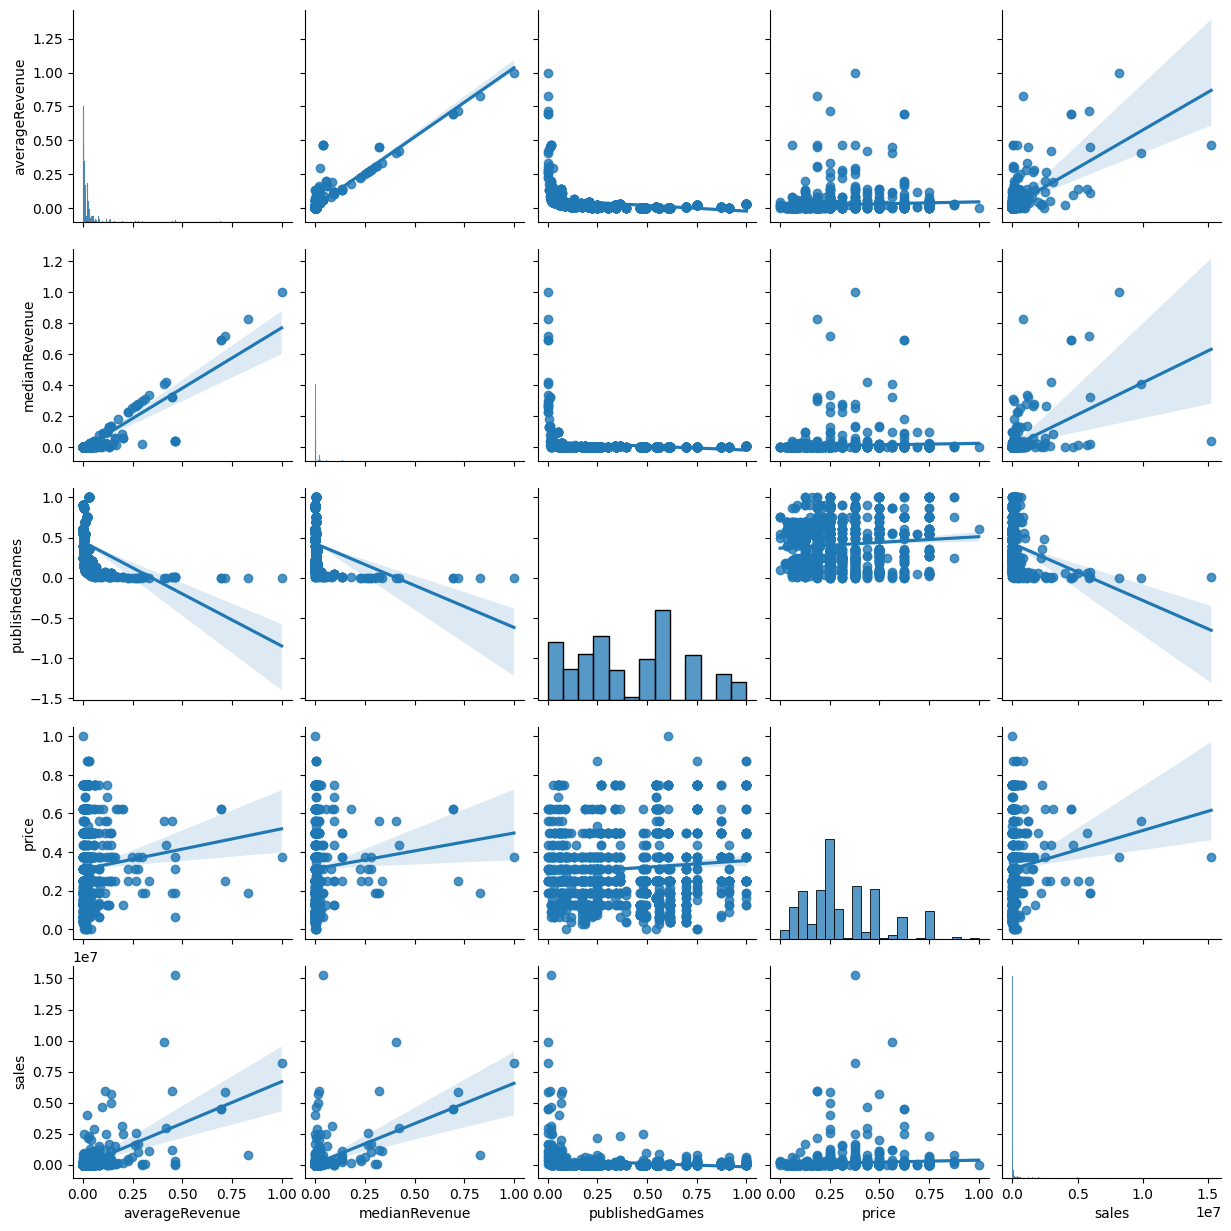

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# 假設 corr_df 是你的數據框
sns.pairplot(corr_df, kind="reg")  # kind="reg" 會添加回歸線

# 顯示圖表
plt.show()

<Axes: >

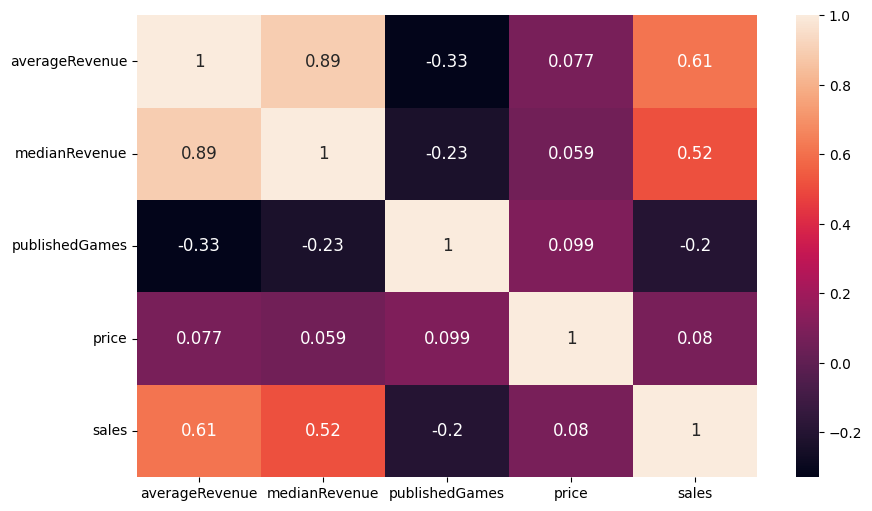

In [18]:
corrmat = corr_df.corr()
fig, ax = plt.subplots(figsize = (10, 6))
sns.heatmap(corrmat, annot = True, annot_kws={'size': 12})

In [72]:
no_one_hot = full_table.iloc[:,:17].drop(columns=["price","medianRevenue"]).drop(columns=["earlyAccess","Early Access","Indie"])
no_one_hot

,sales,averageRevenue,publishedGames,Action,Adventure,Casual,Massively Multiplayer,RPG,Racing,Simulation,Sports,Strategy
0,0.000000e+00,0.011630,0.696133,1,0,0,0,0,0,0,0,0
1,5.691300e+04,0.011630,0.696133,1,0,0,0,0,0,0,0,0
2,1.796316e+05,0.100861,0.038674,1,1,0,0,0,0,0,0,0
3,1.099500e+06,0.054163,0.055249,0,0,0,0,0,0,1,0,0
4,5.393900e+04,0.027177,0.187845,1,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1239,1.050977e+06,0.036138,0.033149,1,1,0,0,0,0,0,0,0
1240,4.581000e+03,0.004767,0.270718,1,1,0,0,0,0,0,0,0
1241,9.695800e+04,0.014553,0.265193,1,0,0,0,0,0,0,0,0
1242,2.590000e+03,0.004767,0.270718,1,1,0,0,0,0,0,0,0


In [73]:
X = no_one_hot.drop(columns="sales").values
Y = no_one_hot['sales'].values

In [27]:
from sklearn.decomposition import PCA

# 1. 應用 PCA
pca = PCA(n_components=0.95)  # 保留 95% 的變異性
X_pca = pca.fit_transform(X)

In [74]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 25)

In [75]:
print(f"Shape of X_train:{X_train.shape}")
print(f"Shape of X_test:{X_test.shape}")
print(f"Shape of y_train:{y_train.shape}")
print(f"Shape of y_test{y_test.shape}")

Shape of X_train:(870, 11)
Shape of X_test:(374, 11)
Shape of y_train:(870,)
Shape of y_test(374,)


In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from collections import Counter
from sklearn.linear_model import LinearRegression,Lasso
from sklearn.metrics import r2_score

In [63]:

lasso = Lasso(alpha = 0.5) # , positive=True
lasso.fit(X_train,y_train)

y_pred_lasso_train = lasso.predict(X_train)
r2_score_lasso_train = lasso.score(X_train, y_train)

y_pred_lasso_test = lasso.predict(X_test)
r2_score_lasso_test = lasso.score(X_test, y_test)

rmse_lasso_train = (np.sqrt(mean_squared_error(y_train, y_pred_lasso_train)))
rmse_lasso_test = (np.sqrt(mean_squared_error(y_test, y_pred_lasso_test)))

print("coef：")
for i, j in zip(full_table.columns, lasso.coef_):
    print(i, j)

coef：
sales 7849004.117200664
averageRevenue 113415.52113420988


In [66]:
print("R2_score (train): ",r2_score_lasso_train)
print("R2_score (test):", r2_score_lasso_test)
print("train_RMSE: ", rmse_lasso_train)
print("test_RMSE: ", rmse_lasso_test)

R2_score (train):  0.460849343976378
R2_score (test): -0.20785439255773475
train_RMSE:  620167.362109402
test_RMSE:  577501.615752212


In [76]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Lasso
from sklearn.pipeline import make_pipeline
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error

# 創建多項式特徵並應用 Lasso 回歸
degree = 2  # 指定多項式的次數
lasso_poly = make_pipeline(PolynomialFeatures(degree), Lasso(alpha=0.1))

# 訓練模型
lasso_poly.fit(X_train, y_train)

# 預測
y_pred_train = lasso_poly.predict(X_train)
y_pred_test = lasso_poly.predict(X_test)

# 計算 R² 分數
r2_score_lasso_train = r2_score(y_train, y_pred_train)
r2_score_lasso_test = r2_score(y_test, y_pred_test)

# 計算 RMSE
rmse_lasso_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
rmse_lasso_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

# 打印結果
print("R² score (train):", r2_score_lasso_train)
print("R² score (test):", r2_score_lasso_test)
print("Train RMSE:", rmse_lasso_train)
print("Test RMSE:", rmse_lasso_test)


R² score (train): 0.6308200726444596
R² score (test): -1.4165593636947573
Train RMSE: 513183.7283847706
Test RMSE: 816854.3878094547


/usr/local/pyenv/versions/3.10.15/envs/dev310-da/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.003e+13, tolerance: 6.206e+10
  model = cd_fast.enet_coordinate_descent(
